In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuración para mejorar la visualización de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [5]:
def cargar_y_preparar_datos(filename, columna_valor, columna_indice='fecha_turno'):
    """
    Carga los datos, procesa el índice para agrupar por fecha
    y promediar los valores de los dos turnos.
    """
    try:
        # Intenta cargar asumiendo que la primera columna es el índice
        df = pd.read_csv(filename, index_col=0, parse_dates=False)
        # Si la columna índice tiene un nombre específico y no es la primera:
        # df = pd.read_csv(filename)
        # df = df.set_index(columna_indice)

        serie = df[columna_valor].copy()
    except FileNotFoundError:
        print(f"Error: El archivo '{filename}' no fue encontrado.")
        return None
    except KeyError:
        print(f"Error: La columna '{columna_valor}' o '{columna_indice}' no se encontró en el archivo.")
        print(f"Columnas disponibles: {df.columns.tolist()}")
        return None

    # Extraer la parte de la fecha del índice actual
    serie.index = serie.index.astype(str) # Asegurar que el índice es string
    fecha_sin_turno = serie.index.str.split('_').str[0]

    # Agrupar por la nueva fecha y calcular la media
    serie_agrupada = serie.groupby(fecha_sin_turno).mean()

    # Convertir el nuevo índice a formato datetime
    serie_agrupada.index = pd.to_datetime(serie_agrupada.index)

    # Ordenar por fecha, por si acaso
    serie_agrupada = serie_agrupada.sort_index()

    print("Datos cargados y procesados:")
    print(serie_agrupada.head())
    print(f"\nLongitud de la serie procesada: {len(serie_agrupada)}")
    print(f"Fecha de inicio: {serie_agrupada.index.min()}")
    print(f"Fecha de fin: {serie_agrupada.index.max()}")
    return serie_agrupada

In [7]:
def analizar_serie_temporal(serie, nombre_serie, periodo_estacionalidad=7):
    """
    Realiza un análisis básico de la serie temporal:
    visualización, descomposición, prueba de estacionariedad y ACF/PACF.
    """
    if serie is None or serie.empty:
        print("La serie está vacía o no se pudo cargar. No se puede analizar.")
        return

    print(f"\n--- Análisis de la Serie Temporal: {nombre_serie} ---")

    # 1. Visualización de la serie temporal
    plt.figure(figsize=(14, 5))
    serie.plot(title=f'Serie Temporal - {nombre_serie}')
    plt.xlabel("Fecha")
    plt.ylabel(nombre_serie)
    plt.show()

    # 2. Descomposición de la serie (Tendencia, Estacionalidad, Residuos)
    # Usamos un modelo aditivo por defecto, podría ser 'multiplicative'
    # El periodo_estacionalidad depende de la naturaleza de tus datos (ej. 7 para semanal, 30 para mensual)
    # Es importante que haya al menos 2 ciclos completos de la estacionalidad para que funcione bien.
    print(f"\nDescomponiendo la serie (periodo={periodo_estacionalidad})...")
    try:
        if len(serie) >= 2 * periodo_estacionalidad:
            descomposicion = seasonal_decompose(serie, model='additive', period=periodo_estacionalidad, extrapolate_trend='freq')
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
            descomposicion.observed.plot(ax=ax1, legend=False)
            ax1.set_ylabel('Observada')
            descomposicion.trend.plot(ax=ax2, legend=False)
            ax2.set_ylabel('Tendencia')
            descomposicion.seasonal.plot(ax=ax3, legend=False)
            ax3.set_ylabel('Estacionalidad')
            descomposicion.resid.plot(ax=ax4, legend=False)
            ax4.set_ylabel('Residuo')
            plt.suptitle(f'Descomposición de {nombre_serie}', y=0.93)
            plt.tight_layout(rect=[0, 0, 1, 0.91]) # Ajustar para el supertítulo
            plt.show()
        else:
            print(f"No hay suficientes datos para una descomposición con periodo {periodo_estacionalidad} (se necesitan al menos {2*periodo_estacionalidad} puntos).")

    except Exception as e:
        print(f"Error durante la descomposición: {e}")


    # 3. Prueba de Estacionariedad (Prueba de Dickey-Fuller Aumentada - ADF)
    print("\nPrueba de Estacionariedad (ADF):")
    # Rellenar NaNs si existen (por ejemplo, si la serie original tenía huecos)
    # Usar ffill y luego bfill por si hay NaNs al principio
    serie_sin_na = serie.fillna(method='ffill').fillna(method='bfill')

    if serie_sin_na.isnull().any():
        print("La serie todavía contiene NaNs después de rellenar. Omitiendo prueba ADF.")
    else:
        resultado_adf = adfuller(serie_sin_na)
        print(f'ADF Statistic: {resultado_adf[0]}')
        print(f'p-value: {resultado_adf[1]}')
        print('Critical Values:')
        for key, value in resultado_adf[4].items():
            print(f'\t{key}: {value}')

        if resultado_adf[1] <= 0.05:
            print("Conclusión: La serie es probablemente estacionaria (se rechaza la hipótesis nula).")
        else:
            print("Conclusión: La serie es probablemente no estacionaria (no se puede rechazar la hipótesis nula).")

    # 4. Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)
    print("\nGráficos ACF y PACF:")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    plot_acf(serie_sin_na, ax=ax1, lags=min(40, len(serie_sin_na)//2 - 1)) # Mostrar hasta 40 lags o la mitad de la serie
    plot_pacf(serie_sin_na, ax=ax2, lags=min(40, len(serie_sin_na)//2 - 1), method='ywm') # method='ols' o 'ywm'
    plt.tight_layout()
    plt.show()

In [9]:
def graficar_componente_estacional_detalle(serie, nombre_serie, periodo_a_probar, num_ciclos_a_visualizar=4):
    """
    Realiza la descomposición estacional y grafica únicamente el componente estacional
    con un eje X detallado para ayudar a identificar el periodo de repetición.

    Args:
        serie (pd.Series): La serie temporal procesada (índice debe ser de tipo datetime).
        nombre_serie (str): Nombre de la serie para los títulos de la gráfica.
        periodo_a_probar (int): El periodo que se sospecha o se quiere probar para la estacionalidad
                                 (e.g., 7 para semanal, 30 para mensual).
        num_ciclos_a_visualizar (int): Cuántos ciclos del 'periodo_a_probar' se mostrarán
                                       inicialmente en el gráfico para mayor claridad.
    """
    if serie is None or serie.empty:
        print("Error: La serie de datos está vacía o no se ha proporcionado.")
        return
    
    if not isinstance(serie.index, pd.DatetimeIndex):
        print("Error: El índice de la serie debe ser de tipo pd.DatetimeIndex.")
        return

    if len(serie) < 2 * periodo_a_probar:
        print(f"Advertencia: La longitud de la serie ({len(serie)} puntos) es menor que el doble "
              f"del periodo a probar ({2 * periodo_a_probar} puntos). "
              f"La descomposición podría no ser fiable o fallar.")
        # Podrías optar por no continuar si es muy corto, o dejar que statsmodels falle.
        # Por ahora, se intentará, pero statsmodels podría lanzar un error.
        # return # Descomentar para no intentar si es muy corto

    print(f"\n--- Visualizando Componente Estacional para '{nombre_serie}' ---")
    print(f"Probando con un periodo de: {periodo_a_probar} días")

    try:
        # Realizar la descomposición estacional
        # 'extrapolate_trend='freq'' ayuda a manejar NaNs que pueden surgir en los extremos de la tendencia
        descomposicion = seasonal_decompose(serie, model='additive', period=periodo_a_probar, extrapolate_trend='freq')
        componente_estacional = descomposicion.seasonal
        
        plt.figure(figsize=(16, 7))
        
        # Para mayor claridad, graficamos solo los primeros 'num_ciclos_a_visualizar' ciclos
        # o toda la serie si es más corta que eso.
        puntos_a_visualizar = min(len(componente_estacional), periodo_a_probar * num_ciclos_a_visualizar)
        
        segmento_a_graficar = componente_estacional.iloc[:puntos_a_visualizar]
        segmento_a_graficar.plot()
        
        plt.title(f'Componente Estacional de {nombre_serie} (Periodo Probado = {periodo_a_probar} días)\n'
                  f'Mostrando los primeros {puntos_a_visualizar} días (aprox. {num_ciclos_a_visualizar} ciclos de {periodo_a_probar} días)')
        plt.xlabel("Fecha")
        plt.ylabel("Magnitud del Componente Estacional")
        plt.grid(True, which='major', linestyle='--', linewidth=0.7)
        plt.axhline(0, color='black', linestyle='-', linewidth=0.8) # Línea en cero para referencia

        # Mejorar el formato y la frecuencia de los ticks del eje X
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d (%a)')) # Formato: Año-Mes-Día (Día de la semana abreviado)
        
        # Ajustar el localizador de ticks basado en la cantidad de puntos a visualizar
        if puntos_a_visualizar <= periodo_a_probar * 2: # Si son 1 o 2 ciclos
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Tick para cada día
            plt.xticks(rotation=70, ha='center')
        elif puntos_a_visualizar <= periodo_a_probar * 5: # Si son hasta 5 ciclos
            # Intentar poner un tick cada 'periodo_a_probar / N' días o cada X días
            # Por ejemplo, si el periodo es 7, un tick cada día o cada 2 días
            if periodo_a_probar == 7: # Semanal
                 ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
            else: # Otros periodos, ticks semanales si es un rango largo
                 ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) # Tick cada Lunes
            plt.xticks(rotation=45, ha='right')
        else: # Para rangos más largos, ticks semanales o mensuales
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1)) # Tick cada Lunes
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout() # Ajusta el plot para que todo encaje bien
        plt.show()
        
        print(f"\n>>> ¿Cómo interpretar este gráfico para '{nombre_serie}' con periodo={periodo_a_probar}?")
        print(f"1. Busca un patrón que se repita CLARAMENTE cada {periodo_a_probar} días.")
        print(f"2. El patrón debe ser consistente a lo largo de los {num_ciclos_a_visualizar} ciclos mostrados (y si graficaras toda la serie estacional, debería mantenerse).")
        print("3. Si el patrón es irregular, o no parece repetirse cada N días, entonces el 'periodo_a_probar' actual podría no ser el correcto.")
        print("4. Prueba con diferentes valores para 'periodo_a_probar'. Comunes para datos diarios son:")
        print("   - 7 (semanal)")
        print("   - 14 (quincenal)")
        print("   - ~30 (mensual, puedes probar 28, 30 o 30.4375 si tienes datos muy largos)")
        print("   - ~91 (trimestral)")
        print("   - También puedes usar la ACF: si ves picos significativos en la ACF en lags como 7, 14, 21, etc., eso sugiere un periodo de 7.")

    except ValueError as ve:
        print(f"Error de Valor durante la descomposición o graficación: {ve}")
        print("Esto puede ocurrir si el 'periodo_a_probar' es demasiado grande para la longitud de la serie, "
              "o si la serie tiene muchos NaNs al principio/final que no se pueden manejar.")
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}")

Datos cargados y procesados:
date_index
2024-01-02    87.867405
2024-01-03    86.719210
2024-01-04    87.922880
2024-01-05    89.459329
2024-01-06    87.098527
Name: ag_recuperacion, dtype: float64

Longitud de la serie procesada: 421
Fecha de inicio: 2024-01-02 00:00:00
Fecha de fin: 2025-03-31 00:00:00

--- Análisis de la Serie Temporal: ag_recuperacion ---


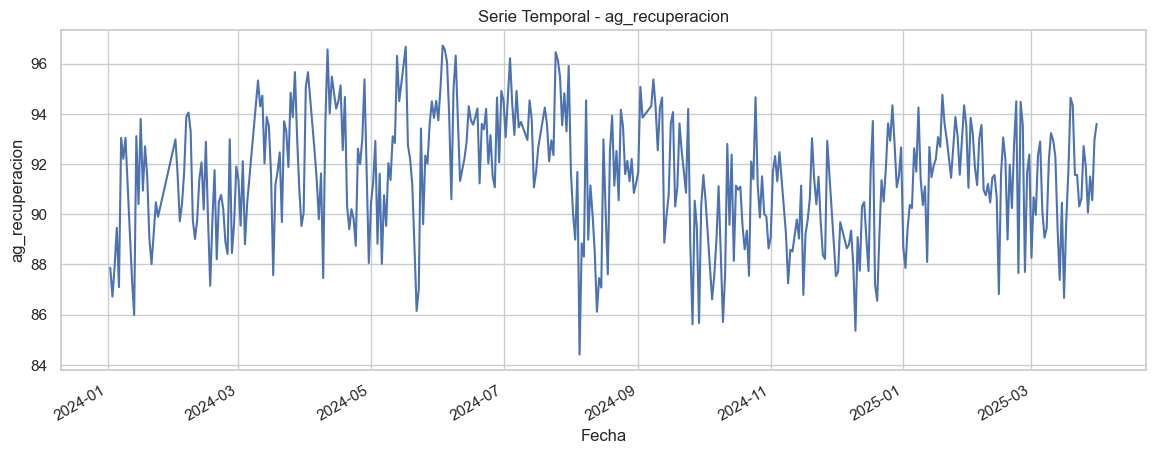


Descomponiendo la serie (periodo=7)...


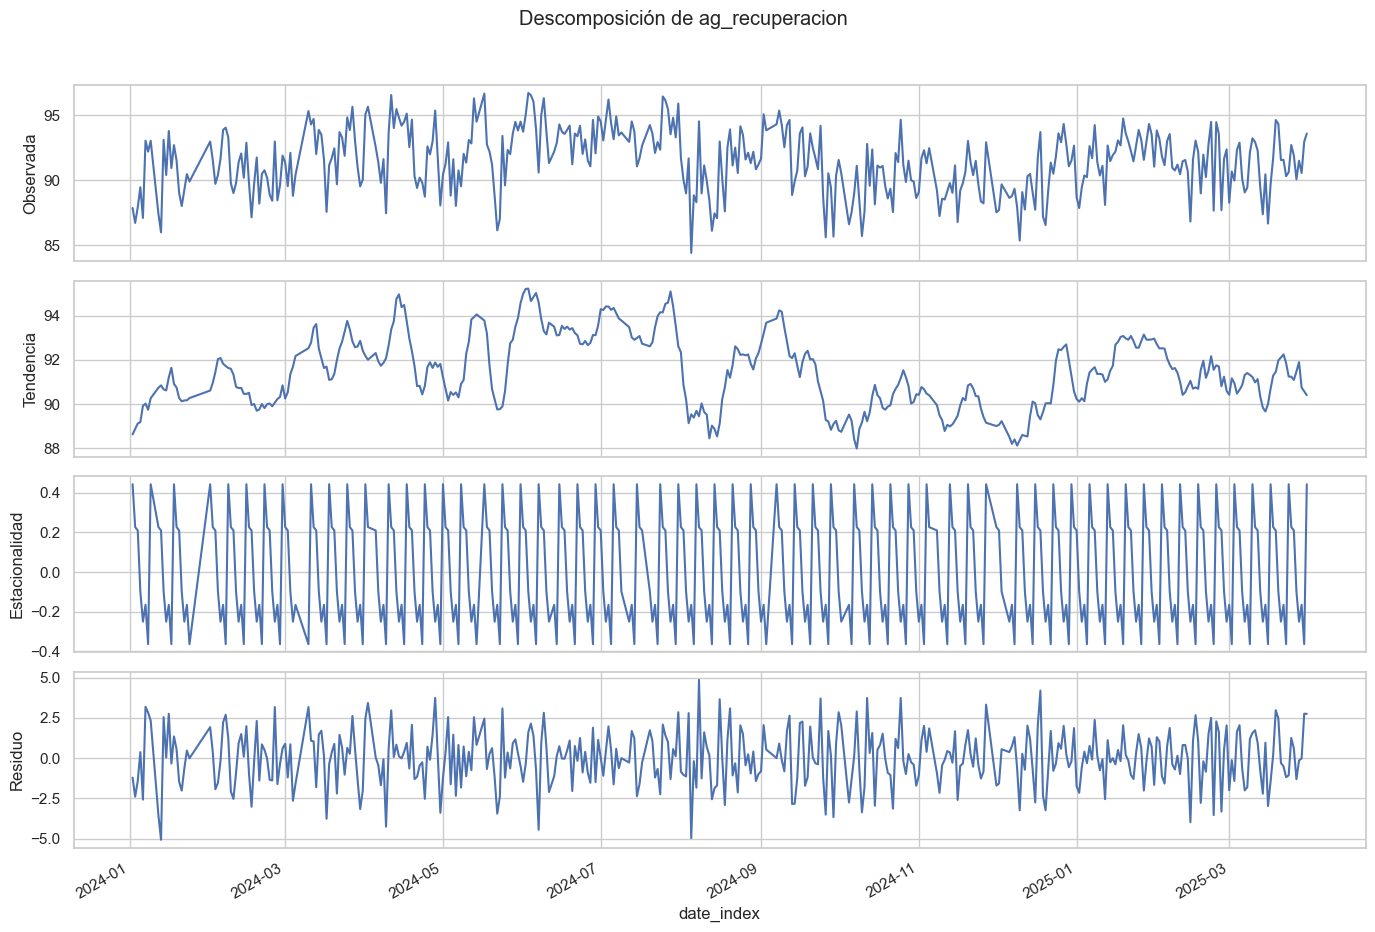


Prueba de Estacionariedad (ADF):
ADF Statistic: -6.452510183938634
p-value: 1.5112173083999843e-08
Critical Values:
	1%: -3.446129402876608
	5%: -2.8684960761128346
	10%: -2.570475362616382
Conclusión: La serie es probablemente estacionaria (se rechaza la hipótesis nula).

Gráficos ACF y PACF:


C:\Users\Cris2\AppData\Local\Temp\ipykernel_3276\402606724.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_sin_na = serie.fillna(method='ffill').fillna(method='bfill')


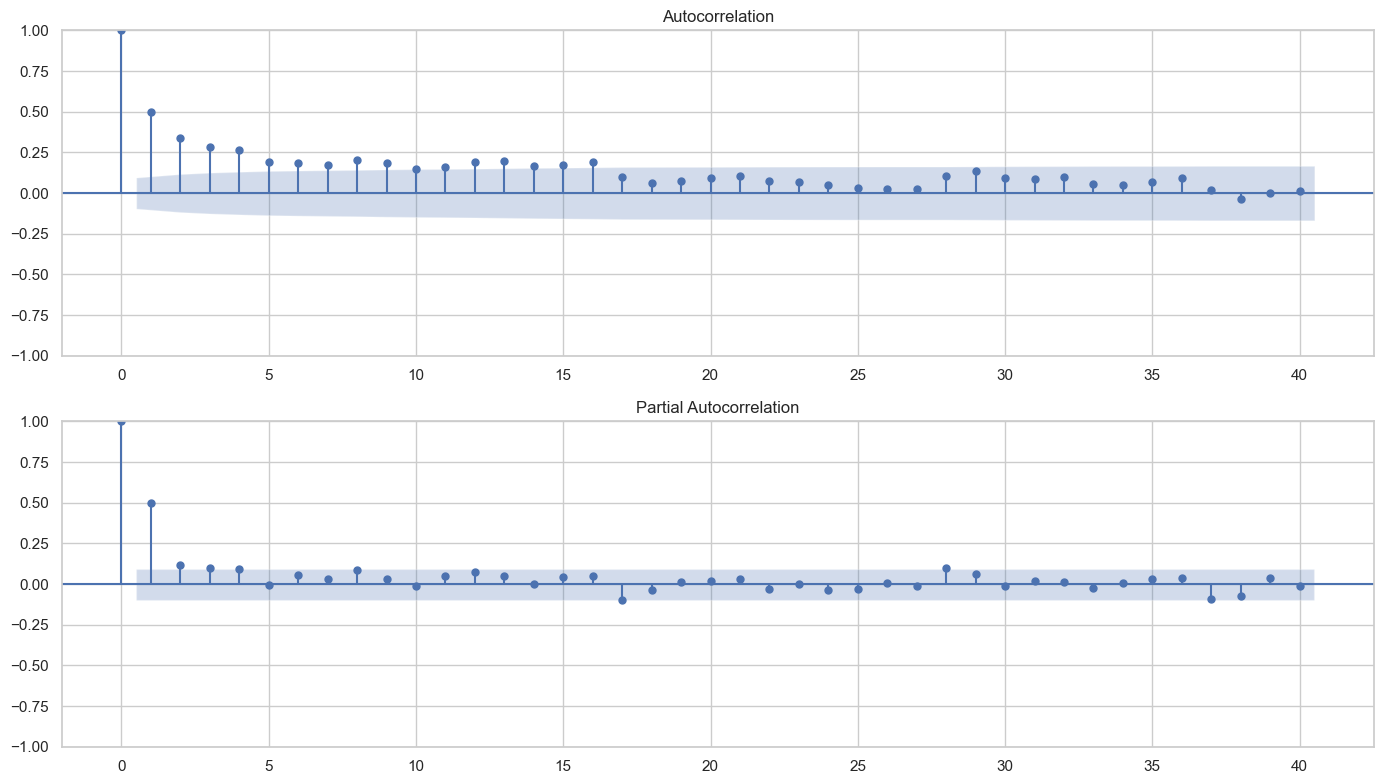


--- Visualizando Componente Estacional para 'ag_recuperacion' ---
Probando con un periodo de: 7 días
Ocurrió un error inesperado: name 'mdates' is not defined

--- Visualizando Componente Estacional para 'ag_recuperacion' ---
Probando con un periodo de: 30 días
Ocurrió un error inesperado: name 'mdates' is not defined

--- Visualizando Componente Estacional para 'ag_recuperacion' ---
Probando con un periodo de: 14 días
Ocurrió un error inesperado: name 'mdates' is not defined


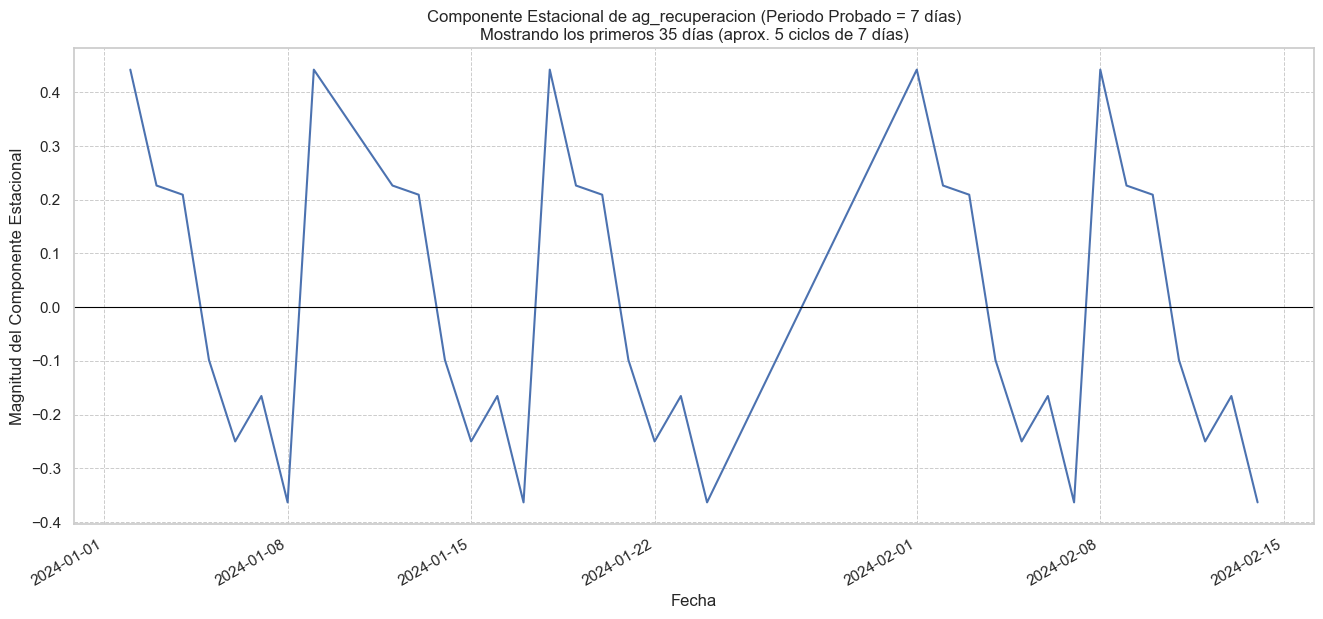

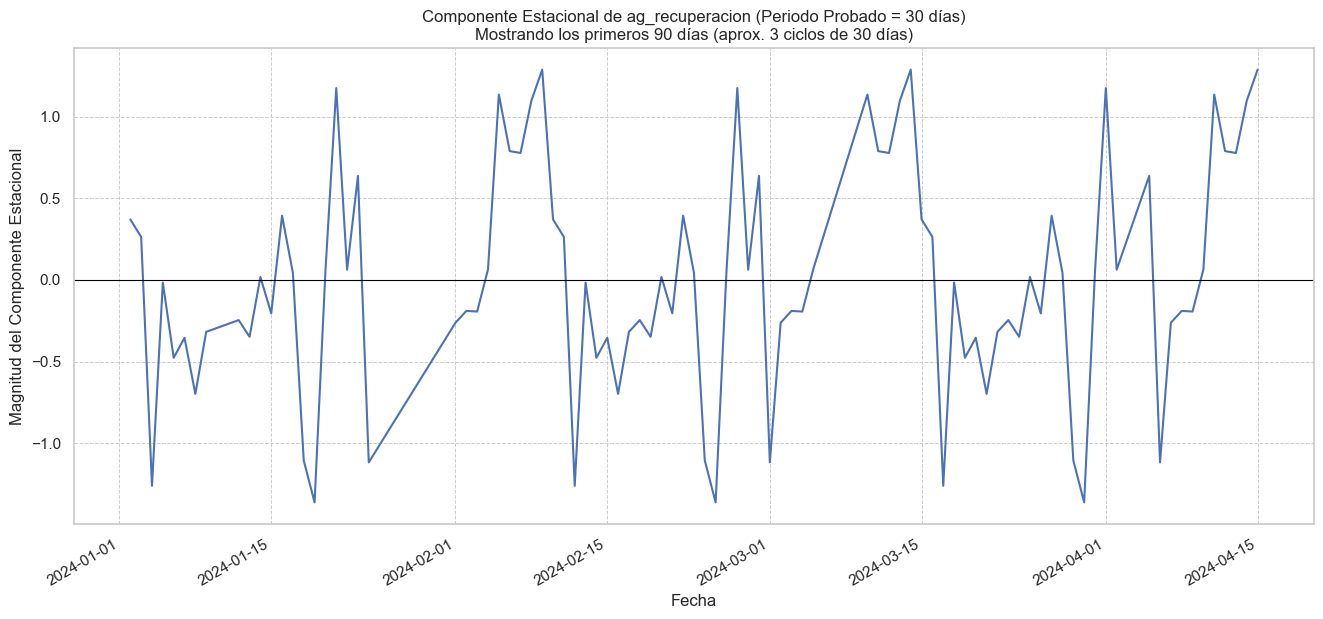

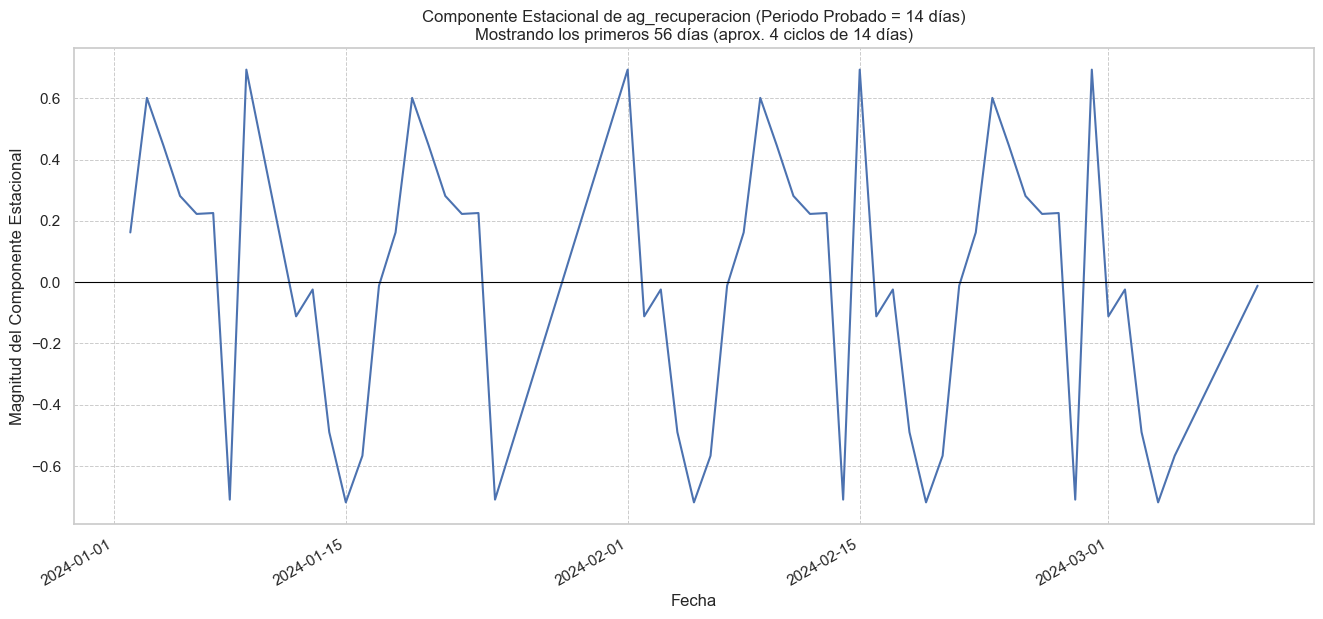

In [11]:
# --- Ejecución del Análisis ---
filename = 'data_variables_objetivo.csv'
columna_a_analizar = 'ag_recuperacion'

# Cargar y preparar los datos
serie_procesada = cargar_y_preparar_datos(filename, columna_a_analizar)

# Si los datos se cargaron correctamente, realizar el análisis
if serie_procesada is not None:
    # Puedes ajustar 'periodo_estacionalidad' según creas conveniente.
    # Por ejemplo, 7 para datos diarios con posible ciclo semanal.
    # Si tus datos después de agrupar abarcan varios años, podrías probar ~365.
    # Con 416 puntos diarios, 7 es un buen comienzo.
    analizar_serie_temporal(serie_procesada, columna_a_analizar, periodo_estacionalidad=7)

# # Una vez que 'serie_procesada' está lista:
if 'serie_procesada' in locals() and serie_procesada is not None:
#     # Prueba 1: Sospecha de estacionalidad semanal (periodo = 7)
    graficar_componente_estacional_detalle(serie_procesada, columna_a_analizar, periodo_a_probar=7, num_ciclos_a_visualizar=5)
#
#     # Prueba 2: Si la semanal no fue clara, prueba con otro periodo, ej. mensual (aprox. 30)
    graficar_componente_estacional_detalle(serie_procesada, columna_a_analizar, periodo_a_probar=30, num_ciclos_a_visualizar=3)
#
#     # Prueba 3: Quizás un ciclo de 14 días
    graficar_componente_estacional_detalle(serie_procesada, columna_a_analizar, periodo_a_probar=14, num_ciclos_a_visualizar=4)
else:
    print("Por favor, asegúrate de que 'serie_procesada' esté cargada y disponible.")


In [13]:
def generar_caracteristicas_temporales(df_entrada, nombre_columna_objetivo,
                                       num_lags=14, # Dado que pronosticas t+14
                                       ventanas_rolling=[3, 5, 7, 14], # Ventanas para estadísticas móviles
                                       periodo_estacional_principal=7):
    """
    Genera un conjunto comprensivo de características para una serie temporal.

    Args:
        df_entrada (pd.DataFrame): DataFrame con un DatetimeIndex y la columna objetivo.
        nombre_columna_objetivo (str): El nombre de la columna de la variable objetivo.
        num_lags (int): Número de características de lag a crear.
        ventanas_rolling (list): Lista de tamaños de ventana para estadísticas móviles.
        periodo_estacional_principal (int): El periodo estacional principal (ej. 7 para semanal).

    Returns:
        pd.DataFrame: DataFrame con la columna objetivo original y las características añadidas.
    """
    if not isinstance(df_entrada.index, pd.DatetimeIndex):
        raise ValueError("El DataFrame de entrada debe tener un DatetimeIndex.")

    df = df_entrada.copy()
    serie_objetivo = df[nombre_columna_objetivo]

    # 1. Características de Lag (Valores Rezagados)
    # Estos usan valores pasados de la serie objetivo.
    for i in range(1, num_lags + 1):
        df[f'lag_{i}'] = serie_objetivo.shift(i)

    # 2. Características de Ventana Móvil (Rolling Window Features)
    # Usamos .shift(1) para asegurar que estas estadísticas se calculan usando datos
    # hasta el periodo anterior, evitando fuga de datos si se predice el valor actual.
    for ventana in ventanas_rolling:
        df[f'rolling_mean_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).mean().shift(1)
        df[f'rolling_std_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).std().shift(1)
        df[f'rolling_min_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).min().shift(1)
        df[f'rolling_max_{ventana}'] = serie_objetivo.rolling(window=ventana, min_periods=1).max().shift(1)

    # 3. Características Basadas en Fecha/Tiempo
    df['dia_semana'] = df.index.dayofweek  # Lunes=0, Domingo=6
    df['dia_mes'] = df.index.day
    df['dia_ano'] = df.index.dayofyear
    df['mes'] = df.index.month
    df['trimestre'] = df.index.quarter
    df['semana_iso'] = df.index.isocalendar().week.astype(int) # Semana ISO del año
    df['ano'] = df.index.year

    # Crear variables dummy (one-hot encoding) para el día de la semana
    # drop_first=False para mantener todas las categorías, útil para árboles de decisión.
    # Para modelos lineales, drop_first=True puede ser preferible para evitar multicolinealidad.
    df_dow_dummies = pd.get_dummies(df['dia_semana'], prefix='dia_sem', drop_first=False)
    df = pd.concat([df, df_dow_dummies], axis=1)

    # (Opcional) Crear variables dummy para el mes
    # df_mes_dummies = pd.get_dummies(df['mes'], prefix='mes_num', drop_first=False)
    # df = pd.concat([df, df_mes_dummies], axis=1)


    # 4. Características de Fourier para la Estacionalidad Semanal (periodo_estacional_principal=7)
    # Estas ayudan a modelar patrones cíclicos de forma suave.
    if periodo_estacional_principal == 7: # Específico para semanal
        # Usamos df['dia_semana'] (0-6) para el cálculo
        for k in range(1, (periodo_estacional_principal // 2) + 1): # Para periodo 7, k será 1, 2, 3
            df[f'sin_semanal_{k}'] = np.sin(2 * np.pi * k * df['dia_semana'] / periodo_estacional_principal)
            df[f'cos_semanal_{k}'] = np.cos(2 * np.pi * k * df['dia_semana'] / periodo_estacional_principal)
    # Podrías añadir términos genéricos de Fourier si sospechas otros periodos no ligados al calendario.

    # 5. Característica de Tendencia (índice de tiempo simple)
    df['tendencia_idx'] = np.arange(len(df.index))

    # 6. Características de Momentum / Tasa de Cambio
    df['diff_1'] = serie_objetivo.diff(periods=1) # Diferencia con el día anterior
    if periodo_estacional_principal > 1:
        # Diferencia con el mismo día de la semana anterior (para periodo 7)
        df[f'diff_estacional_{periodo_estacional_principal}'] = serie_objetivo.diff(periods=periodo_estacional_principal)
    
    # Tu característica de momentum original (diferencia de 4 periodos)
    df['momentum_custom_4'] = serie_objetivo - serie_objetivo.shift(4)

    # (Opcional: Si quieres re-incluir RSI)
    # df['rsi_56'] = compute_rsi(serie_objetivo, window=56)
    
    # Nota: Muchas características creadas (lags, rolling, diffs) introducirán NaNs
    # al principio del DataFrame. Estos deben ser manejados (ej. eliminar filas o imputar)
    # antes de entrenar un modelo.
    print("Generación de características completada.")
    print(f"Forma del DataFrame original: {df_entrada.shape}, Forma del DataFrame con características: {df.shape}")
    numero_nans_estimado = max(num_lags, max(ventanas_rolling, default=0) if ventanas_rolling else 0)
    print(f"Se introducirán NaNs al inicio (aprox. {numero_nans_estimado} filas o más).")
    print("Considera usar df.head(), df.tail() y df.info() para inspeccionar el resultado.")
    
    return df

In [15]:
# Asumiendo que 'serie_procesada' es tu Serie de Pandas diaria
# y 'columna_a_analizar' es 'pb_recuperacion'
df_para_features = serie_procesada.to_frame(name=columna_a_analizar)

In [17]:
if 'df_para_features' in locals() and df_para_features is not None:
    df_con_features = generar_caracteristicas_temporales(
        df_entrada=df_para_features,
        nombre_columna_objetivo=columna_a_analizar, # ej. 'pb_recuperacion'
        num_lags=16,              # Número de lags (ej. para predecir t+14)
        ventanas_rolling=[3, 5, 7, 14], # Ventanas para medias/std móviles
        periodo_estacional_principal=7 # Estacionalidad semanal confirmada
    )

    print("\nPrimeras 20 filas del DataFrame con características (contiene NaNs al principio):")
    print(df_con_features.head(20))

    print("\nÚltimas 5 filas del DataFrame con características:")
    print(df_con_features.tail())

    print("\nInformación sobre el nuevo DataFrame:")
    df_con_features.info()

    #Antes de entrenar modelos, usualmente eliminarías las filas con NaNs
    df_final_para_modelo = df_con_features.dropna()
    print(f"\nForma después de eliminar NaNs: {df_final_para_modelo.shape}")
else:     
    print("Asegúrate de que 'serie_procesada' (convertida a DataFrame) esté disponible.")

Generación de características completada.
Forma del DataFrame original: (421, 1), Forma del DataFrame con características: (421, 57)
Se introducirán NaNs al inicio (aprox. 16 filas o más).
Considera usar df.head(), df.tail() y df.info() para inspeccionar el resultado.

Primeras 20 filas del DataFrame con características (contiene NaNs al principio):
            ag_recuperacion      lag_1      lag_2      lag_3      lag_4  \
date_index                                                                
2024-01-02        87.867405        NaN        NaN        NaN        NaN   
2024-01-03        86.719210  87.867405        NaN        NaN        NaN   
2024-01-04        87.922880  86.719210  87.867405        NaN        NaN   
2024-01-05        89.459329  87.922880  86.719210  87.867405        NaN   
2024-01-06        87.098527  89.459329  87.922880  86.719210  87.867405   
2024-01-07        93.046193  87.098527  89.459329  87.922880  86.719210   
2024-01-08        92.210640  93.046193  87.09852

Forma de X_all después de la preparación: (398, 56)
Forma de y_all después de la preparación: (398,)

Iniciando validación walk-forward para pronóstico de t+7...
Tamaño total después de preparación: 398
Tamaño de entrenamiento inicial: 278
Tamaño de prueba (orígenes de pronóstico): 120
Validación walk-forward finalizada.

Pronóstico para t+7 con validación walk-forward y normalización:
MAE: 1.6989
RMSE: 2.1072
MAPE: 0.0187
SMAPE: 1.87%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


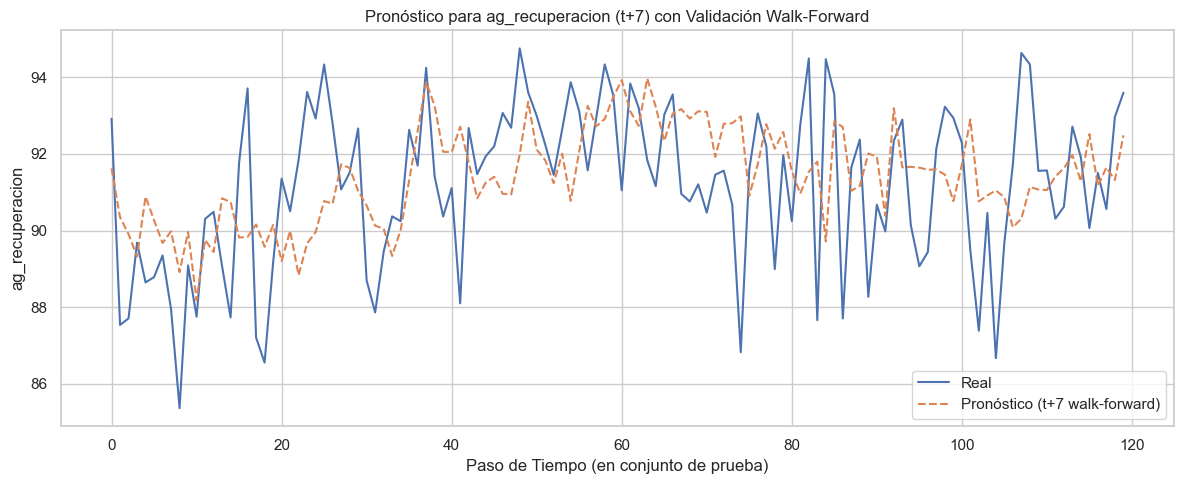

In [19]:
import pandas as pd
import numpy as np
import lightgbm as lgb # Importar LightGBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 2. Crear la VERDADERA variable objetivo para t+N (ej. t+14)
horizonte_real = 7 # O el n_steps_ahead que desees
df_para_modelo = df_con_features.copy()
df_para_modelo['objetivo_futuro_t_mas_N'] = df_para_modelo['ag_recuperacion'].shift(-horizonte_real)

X = df_para_modelo.drop(columns=['ag_recuperacion', 'objetivo_futuro_t_mas_N'])
y = df_para_modelo['objetivo_futuro_t_mas_N']

# 4. Eliminar NaNs DESPUÉS de crear el objetivo futuro y definir X.
#    Esto eliminará las filas donde las features no se pudieron calcular (inicio)
#    Y donde el objetivo futuro no existe (final).
df_final_para_modelo = pd.concat([X, y], axis=1).dropna()

# 5. Ahora, separa de nuevo X e y para el modelo a partir de df_final_para_modelo
y_final = df_final_para_modelo[y.name] # y.name será 'objetivo_futuro_t_mas_N'
X_final = df_final_para_modelo.drop(columns=[y.name])

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

columna = 'ag_recuperacion' # Columna a pronosticar
n_lags = 17                  # Número de lags para usar como características
n_steps_ahead = 7          # Horizonte de pronóstico (t+10)

# Separar X_all (características finales) e y_all (objetivo final)
X_all = X_final
y_all = y_final

# Resetear el índice para usar iloc en el bucle de walk-forward
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación. Verifica los NaNs o la longitud de los datos.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X.columns)

# La longitud para el bucle ahora se basa en X_all (o y_all, que tienen la misma longitud)
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")


if test_size <= 0:
    print("Error: No hay datos de prueba. Revisa el tamaño de tus datos o la proporción de entrenamiento.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)): # El bucle itera sobre el índice de X_all_scaled/y_all
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]        # y_train ahora contiene los valores de t+n_steps_ahead
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]          # y_test es el valor real en t+n_steps_ahead

    model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, num_leaves=31, random_state=42, n_jobs=-1, verbose=-1)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions) # Renombrado para claridad
y_true_array = np.array(actuals)   # Renombrado para claridad

if len(y_pred_array) == 0:
    print("No se generaron predicciones. No se pueden calcular métricas.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    # Calcular SMAPE con cuidado para evitar división por cero si y_true_array y y_pred_array son cero
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10) # Añadir epsilon
    smape = np.mean(smape_terms) * 100


    print(f'\nPronóstico para t+{n_steps_ahead} con validación walk-forward y normalización:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con Validación Walk-Forward')
    plt.xlabel('Paso de Tiempo (en conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Forma de X_all después de la preparación: (398, 56)
Forma de y_all después de la preparación: (398,)

Iniciando validación walk-forward para pronóstico de t+7...
Tamaño total después de preparación: 398
Tamaño de entrenamiento inicial: 278
Tamaño de prueba (orígenes de pronóstico): 120
Validación walk-forward finalizada.

Pronóstico para t+7 con validación walk-forward y normalización:
MAE: 1.6010
RMSE: 1.9923
MAPE: 0.0177
SMAPE: 1.76%


D:\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


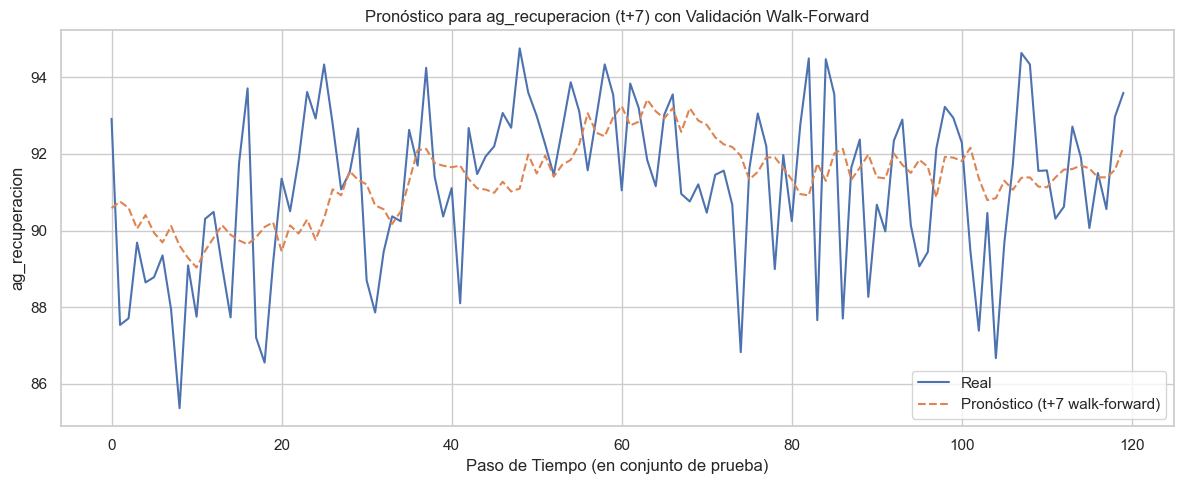

In [21]:
# 2. Crear la VERDADERA variable objetivo para t+N (ej. t+14)
horizonte_real = 7 # O el n_steps_ahead que desees
df_para_modelo = df_con_features.copy()
df_para_modelo['objetivo_futuro_t_mas_N'] = df_para_modelo['ag_recuperacion'].shift(-horizonte_real)

X = df_para_modelo.drop(columns=['ag_recuperacion', 'objetivo_futuro_t_mas_N'])
y = df_para_modelo['objetivo_futuro_t_mas_N']

# 4. Eliminar NaNs DESPUÉS de crear el objetivo futuro y definir X.
#    Esto eliminará las filas donde las features no se pudieron calcular (inicio)
#    Y donde el objetivo futuro no existe (final).
df_final_para_modelo = pd.concat([X, y], axis=1).dropna()

# 5. Ahora, separa de nuevo X e y para el modelo a partir de df_final_para_modelo
y_final = df_final_para_modelo[y.name] # y.name será 'objetivo_futuro_t_mas_N'
X_final = df_final_para_modelo.drop(columns=[y.name])

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

columna = 'ag_recuperacion' # Columna a pronosticar
n_lags = 16                  # Número de lags para usar como características
n_steps_ahead = 7          # Horizonte de pronóstico (t+10)

# Separar X_all (características finales) e y_all (objetivo final)
X_all = X_final
y_all = y_final

# Resetear el índice para usar iloc en el bucle de walk-forward
X_all = X_all.reset_index(drop=True)
y_all = y_all.reset_index(drop=True)

print(f"Forma de X_all después de la preparación: {X_all.shape}")
print(f"Forma de y_all después de la preparación: {y_all.shape}")

if X_all.empty or y_all.empty:
    print("ERROR: X_all o y_all están vacíos después de la preparación. Verifica los NaNs o la longitud de los datos.")
    exit()

scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X.columns)

# La longitud para el bucle ahora se basa en X_all (o y_all, que tienen la misma longitud)
initial_train_size = int(len(X_all_scaled) * 0.7)
predictions = []
actuals = []

print(f"\nIniciando validación walk-forward para pronóstico de t+{n_steps_ahead}...")
test_size = len(X_all_scaled) - initial_train_size
print(f"Tamaño total después de preparación: {len(X_all_scaled)}")
print(f"Tamaño de entrenamiento inicial: {initial_train_size}")
print(f"Tamaño de prueba (orígenes de pronóstico): {test_size}")


if test_size <= 0:
    print("Error: No hay datos de prueba. Revisa el tamaño de tus datos o la proporción de entrenamiento.")
    exit()

for i in range(initial_train_size, len(X_all_scaled)): # El bucle itera sobre el índice de X_all_scaled/y_all
    X_train = X_all_scaled.iloc[:i]
    y_train = y_all.iloc[:i]        # y_train ahora contiene los valores de t+n_steps_ahead
    X_test = X_all_scaled.iloc[i:i+1]
    y_test = y_all.iloc[i]          # y_test es el valor real en t+n_steps_ahead

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_features='sqrt', min_samples_split=5, min_samples_leaf=3)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]

    predictions.append(y_pred)
    actuals.append(y_test)

print("Validación walk-forward finalizada.")

y_pred_array = np.array(predictions) # Renombrado para claridad
y_true_array = np.array(actuals)   # Renombrado para claridad

if len(y_pred_array) == 0:
    print("No se generaron predicciones. No se pueden calcular métricas.")
else:
    mae = mean_absolute_error(y_true_array, y_pred_array)
    rmse = mean_squared_error(y_true_array, y_pred_array, squared=False)
    mape = mean_absolute_percentage_error(y_true_array, y_pred_array)
    # Calcular SMAPE con cuidado para evitar división por cero si y_true_array y y_pred_array son cero
    denominator_smape = np.abs(y_true_array) + np.abs(y_pred_array)
    smape_terms = 2 * np.abs(y_pred_array - y_true_array) / (denominator_smape + 1e-10) # Añadir epsilon
    smape = np.mean(smape_terms) * 100


    print(f'\nPronóstico para t+{n_steps_ahead} con validación walk-forward y normalización:')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}')
    print(f'SMAPE: {smape:.2f}%')

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_array, label='Real')
    plt.plot(y_pred_array, label=f'Pronóstico (t+{n_steps_ahead} walk-forward)', linestyle='--')
    plt.title(f'Pronóstico para {columna} (t+{n_steps_ahead}) con Validación Walk-Forward')
    plt.xlabel('Paso de Tiempo (en conjunto de prueba)')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()